# Multi-agent Collaboration


## Overview

A single agent can usually perform well using a small set of tools to solve a specific task. However, even powerful models like GPT-4 may struggle when given many different tools to solve a complex task.

One way to approach complicated tasks is through a _"divide-and-conquer"_ approach. Create a specialized agent for each task and route tasks to the correct _"expert"_.

The code from this notebook is adapted from the [LangGraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration). The ideas in this notebook is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.

The graph that we'll build will look something like the following diagram:

![multi_agent diagram](img/simple_multi_agent_diagram.png)

**Figure 1**: Image from [LangGraph](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration)

## Setup

Before we begin, please make sure you have setup the `.env` file in the project 
directory as described in [`README.md`](README.md).

Next, we will load in the necessary environment variables (e.g., API keys) for this notebook:

In [1]:
import os
from dotenv import load_dotenv

_ = load_dotenv()

assert os.environ.get("GOOGLE_API_KEY")

## Create Agents

The following helper function will help create agents. These agents will then be nodes in the graph.

In [2]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import (
    ChatPromptTemplate, 
    MessagesPlaceholder,
)
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.tools import BaseTool
from langchain_core.runnables import RunnableSequence


def create_agent(
    model: BaseChatModel, 
    tools: list[BaseTool], 
    system_message: str
) -> RunnableSequence:
    """
    Create an agent that will be a node in the graph.

    Args:
        model: The LLM that powers this agent.
        tools: List of tools to be called by the LLM.
        system_message: The system message passed to the LLM 
            to configure its behaviour.

    Returns:
        A chain that can be invoked.
    """
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, "
                "collaborating with other assistants. "
                "Use the provided tools to progress "
                "towards answering the question. "
                "If you are unable to fully answer, "
                "that's OK, another assistant with "
                "different tools will help where "
                "you left off. Execute what you can "
                "to make progress. If you or any of "
                "the other assistants have the "
                "final answer or deliverable, "
                "prefix your response with FINAL ANSWER "
                "so the team knows to stop. "
                "You have access to the following tools: {tool_names}."
                "\n\n"
                "{system_message}",
            ),
            MessagesPlaceholder(
                variable_name="messages"
            ),
        ]
    )
    prompt = prompt.partial(
        system_message=system_message
    )
    prompt = prompt.partial(
        tool_names=", ".join(
            tool.name for tool in tools
        )
    )
    return (
        prompt 
        | model.bind_tools(tools)
    )

## Define Tools

We will also define some tools that our agents will use.

### Fetch historical stock data tool

This tool is used by the `stock_researcher` agent to fetch historical data for a given stock's ticker symbol. This tool uses the [`yfinance`](https://github.com/ranaroussi/yfinance) library to download market data from [Yahoo! finance](https://finance.yahoo.com/).

In [9]:
from typing import Annotated

from langchain_core.tools import tool

import pandas as pd
import yfinance as yf


@tool(
    response_format="content_and_artifact"
)
def get_historical_stock_data(
    ticker_symbol: Annotated[
        str, 
        "A ticker symbol is a stock symbol; "
        "an abbreviation of a company's name that "
        "uniquely identifies its publicly traded "
        "shares on stock exchanges. Examples of "
        "ticker symbols are GOOGL for Google, "
        "AMZN for Amazon, MSFT for Microsoft, "
        "AAPL for Apple."
    ],
) -> tuple[str, pd.DataFrame]:
    """
    Fetch the historical stock data for a given 
    stock ticker symbol.

    Example:
        .. code-block:: python

            # fetch historical stock data for Apple Inc
            get_historical_stock_data('AAPL')

    Returns: 
        A pandas `DataFrame` with columns: 
        `Date`, `Open`, `High`, `Low`, `Close`, `Volume`.
        The `Date` column will be used as the `DatetimeIndex`.
    """
    stock = yf.Ticker(ticker_symbol)    

    # artifact is a pandas DataFrame used by 
    # the plot_chart tool
    hist_data = stock.history(
        # 1 day interval
        interval='1d', 
        # 3 months history
        period='3mo',
        # do NOT Include Dividends and 
        # Stock Splits in results
        actions=False,
    )

    # content is for the LLM
    content = (
        "Successfully fetched historical stock "
        f"data for `{ticker_symbol}`."
    )

    # returns a (content, artifact) tuple
    return (content, hist_data)

Let's try invoking the tool to see what we get back:

In [18]:
from langchain_core.messages import ToolCall

# normally, this would be generated by the LLM
tool_call = ToolCall(
    name="get_historical_stock_data",
    args={
        "ticker_symbol": "SPY"
    },
    id=123,          # required
    type="tool_call" # required
)

tool_result = get_historical_stock_data.invoke(
    input=tool_call
)

In [21]:
tool_result.content

'Successfully fetched historical stock data for `SPY`.'

Below we can see that the tool also returned an artifact, which is a pandas `DataFrame` that will be used by the `plot_chart` tool:

In [23]:
type(tool_result.artifact)

pandas.core.frame.DataFrame

In [24]:
tool_result.artifact.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2024-08-20 00:00:00-04:00,559.150024,560.840027,557.330017,558.700012,33732300
2024-08-21 00:00:00-04:00,559.770020,562.109985,554.729980,560.619995,41514600
2024-08-22 00:00:00-04:00,562.559998,563.179993,554.979980,556.219971,56121500
2024-08-23 00:00:00-04:00,559.530029,563.090027,557.289978,562.130005,50639400
2024-08-26 00:00:00-04:00,563.179993,563.909973,559.049988,560.789978,35739100


### Plot Chart Tool

The tool for plotting charts using `matplotlib` is used by the `chart_generator` agent.

In [66]:
from typing import Annotated

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.dates import ConciseDateFormatter

from langchain_core.tools import tool


@tool
def plot_time_series(
    start_date: Annotated[
        str, 
        "Start date as a string in ISO 8601 date format: "
        "YYYY-MM-DD where years (Y), months (M), days (D). "
        "Example: '2024-08-01' # Day: 1, Month: 8 (August), Year: 2024"
    ],
    end_date: Annotated[
        str, 
        "End date as a string in ISO 8601 date format: "
        "YYYY-MM-DD where years (Y), months (M), days (D). "
        "Example: '2025-09-20' # Day: 20, Month: 9 (September), Year: 2025"
    ],
    data: Annotated[list[float], "List of values for the y-axis."],
    title: Annotated[str, "Concise title for the chart."],
    x_label: Annotated[str, "Concise label for the x-axis."],
    y_label: Annotated[str, "Concise label for the y-axis."],
) -> None:
    """
    Plot a line chart of a time series. 
    
    The x-axis represents the dates ranging from `start_date` 
    to `end_date` (inclusive) with a step size of 1 day. 
    The y-axis represents the data values for each date.

    Example:
        # Plots average temperature in Paris for 7 days
        plot_time_series(
            start_date='2024-08-01',
            end_date='2024-08-07',
            data=[24.6, 23.0, 19.7, 20.1, 21.2, 21.6, 19.3],
            title='Average Temperature in Paris',
            x_label='Date',
            y_label='Temperature (C°)'
        )    
    """
    fig, ax = plt.subplots(
        figsize=(5, 2.7), 
        layout='constrained'
    )

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(visible=True)

    # Step size of 1 day
    step_day = np.timedelta64(1, 'D')
    
    dates = np.arange(
        start=np.datetime64(start_date), 
        # include end_date
        stop=np.datetime64(end_date) + step_day,
        step=step_day
    )
    
    ax.plot(dates, data)    
    ax.xaxis.set_major_formatter(
        ConciseDateFormatter(
            locator=ax.xaxis.get_major_locator()
        )
    )
    
    plt.show()

Let's inspect some of the attributes associated with this tool:

In [68]:
print(plot_time_series.name, end="\n---\n")
print(plot_time_series.description, end="\n---\n")
print(plot_time_series.args)

plot_time_series
---
Plot a line chart of a time series. 

The x-axis represents the dates ranging from `start_date` 
to `end_date` (inclusive) with a step size of 1 day. 
The y-axis represents the data values for each date.

Example:
    # Plots average temperature in Paris for 7 days
    plot_time_series(
        start_date='2024-08-01',
        end_date='2024-08-07',
        data=[24.6, 23.0, 19.7, 20.1, 21.2, 21.6, 19.3],
        title='Average Temperature in Paris',
        x_label='Date',
        y_label='Temperature (C°)'
    )
---
{'start_date': {'title': 'Start Date', 'description': "Start date as a string in ISO 8601 date format: YYYY-MM-DD where years (Y), months (M), days (D). Example: '2024-08-01' # Day: 1, Month: 8 (August), Year: 2024", 'type': 'string'}, 'end_date': {'title': 'End Date', 'description': "End date as a string in ISO 8601 date format: YYYY-MM-DD where years (Y), months (M), days (D). Example: '2025-09-20' # Day: 20, Month: 9 (September), Year: 2025", 'type

In [69]:
plot_time_series.args_schema.schema()

{'title': 'plot_time_seriesSchema',
 'description': "Plot a line chart of a time series. \n\nThe x-axis represents the dates ranging from `start_date` \nto `end_date` (inclusive) with a step size of 1 day. \nThe y-axis represents the data values for each date.\n\nExample:\n    # Plots average temperature in Paris for 7 days\n    plot_time_series(\n        start_date='2024-08-01',\n        end_date='2024-08-07',\n        data=[24.6, 23.0, 19.7, 20.1, 21.2, 21.6, 19.3],\n        title='Average Temperature in Paris',\n        x_label='Date',\n        y_label='Temperature (C°)'\n    )    ",
 'type': 'object',
 'properties': {'start_date': {'title': 'Start Date',
   'description': "Start date as a string in ISO 8601 date format: YYYY-MM-DD where years (Y), months (M), days (D). Example: '2024-08-01' # Day: 1, Month: 8 (August), Year: 2024",
   'type': 'string'},
  'end_date': {'title': 'End Date',
   'description': "End date as a string in ISO 8601 date format: YYYY-MM-DD where years (Y), m

Let's invoke our tool directly with some tool arguments to see what it outputs:

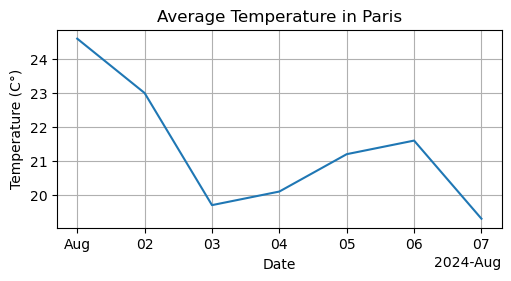

In [70]:
plot_time_series.invoke(
    input={
        "start_date": '2024-08-01',
        "end_date": '2024-08-07',
        "data": [24.6, 23.0, 19.7, 20.1, 21.2, 21.6, 19.3],
        "title": 'Average Temperature in Paris',
        "x_label": 'Date',
        "y_label": 'Temperature (C°)'    
    }    
)  

## Create graph

After we've defined the tools for the agents, we'll create the agents and tell them how to talk to each other using LangGraph.

### Define State

First define the state of the graph. This will just be a list of messages, and a key to track the most recent sender.

In [71]:
import operator
from typing import (
    Annotated, 
    Sequence, 
    TypedDict
)


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each 
# agent and tool.
class AgentState(TypedDict):
    messages: Annotated[
        Sequence[BaseMessage], 
        operator.add
    ]
    sender: str

### Define Agent Nodes

Next, let's define the nodes for the agents. To make things easier, we'll create a helper function to create a node for a given agent.

In [72]:
from typing import Any

from langchain_core.messages import AIMessage
from langchain_core.runnables import Runnable
from langchain.pydantic_v1 import BaseModel


def agent_node(
    state: AgentState, 
    agent: Runnable, 
    name: str
) -> AgentState:
    """
    Create a node on the graph for a given agent.

    Args:
        state: Current state of the graph.
        agent: The agent that can be invoked to get a result.
        name: The name of the node in the graph.
        
    Returns:
        New state of the graph.
    """
    result: [ToolMessage | BaseModel] = agent.invoke(state)
    
    # Convert the agent output into a format that 
    # is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:        
        result_dict = result.dict(
            exclude={"type", "name"}
        )
        result = AIMessage(
            **result_dict, 
            name=name
        )

    return AgentState(
        messages=[result],
        
        # Keep track of the agent that sent 
        # the most recent message, so that we 
        # know who to route to next.
        sender=name,
    )

Create the chat model (LLM) that will power the agents:

In [73]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
)

#### Research Agent

Create the research agent and its node in the graph. The research agent is responsible for searching for answers on the web using the provided web search tool.

In [74]:
from functools import partial

research_agent = create_agent(
    model=llm,
    tools=[web_search_tool],
    system_message=(
        "Given the user's query, your task is to use "
        "the provided tool to search the web for "
        "relevant answers. Provide accurate data "
        "for another AI assistant to plot a chart."
    ),
)
research_agent_node = partial(
    agent_node, 
    agent=research_agent, 
    name="researcher"
)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


#### Chart Generator Agent

Create the chart generator agent and its node in the graph. Given the relevant data, the chart generator agent will plot a chart with the provided function/tool.

In [75]:
chart_agent = create_agent(
    model=llm,
    tools=[plot_time_series],
    system_message=(        
        "Given the relevant data, use the provided "
        "tool to plot a chart of the data."
    )
)
chart_agent_node = partial(
    agent_node, 
    agent=chart_agent, 
    name="chart_generator"
)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


### Define Tool Node

Define a node to run the tools used by the agents.

In [76]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(
    tools=[
        web_search_tool, 
        plot_time_series
    ]
)

### Define Router

Define some of the edge logic that is needed to decide what to do based on results generated by the agents.

In [77]:
from typing import Literal

from langgraph.graph import END


def router(
    state: AgentState
) -> Literal["call_tool", END, "continue"]:
    """
    Routes to different nodes based on the 
    agent's output.

    Args:
        state: Current state of the graph that includes 
            the previous agent's output.

    Returns:
        One of the following strings:
        - `call_tool`: If an agent is invoking a tool.
        - `__end__`: If an agent decides that the work is finished.
        - `continue`: Hand control over to the other agent.
    """
    messages = state["messages"]
    last_message: AIMessage = messages[-1]    

    if last_message.tool_calls:
        # Previous agent is invoking a tool
        return "call_tool"
    
    if "FINAL ANSWER" in last_message.content:
        # One of the agent has decided that 
        # the work is finished
        return END

    # Hand control over to the other agent
    return "continue"

### Build the Graph

We can now put it all together and build the graph.

In [78]:
from langgraph.graph import (
    START, 
    StateGraph
)


workflow = StateGraph(
    state_schema=AgentState
)

workflow.add_node("researcher", research_agent_node)
workflow.add_node("chart_generator", chart_agent_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    source="researcher",
    path=router,
    path_map={
        "continue": "chart_generator", 
        "call_tool": "call_tool", 
        "__end__": END
    },
)

workflow.add_conditional_edges(
    source="chart_generator",
    path=router,
    path_map={
        "continue": "researcher", 
        "call_tool": "call_tool", 
        "__end__": END
    },
)

# Each agent node updates the 'sender' field
# the tool calling node does not, meaning
# this edge will route back to the original agent
# who invoked the tool
workflow.add_conditional_edges(
    source="call_tool",
    path=lambda state: state["sender"],
    path_map={
        "researcher": "researcher",
        "chart_generator": "chart_generator",
    }
)

workflow.add_edge(
    start_key=START, 
    end_key="researcher"
)

graph = workflow.compile()

Let's visualize the graph that we've built:

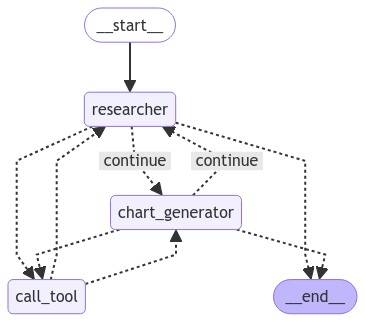

In [79]:
from IPython.display import Image, display

display(
    Image(
        graph.get_graph(xray=True).draw_mermaid_png()
    )
)

## Invoke

After we have built the graph, we can now invoke it. Let's have it plot a chart for us:

In [ ]:
events = graph.stream(
    input={
        "messages": [
            HumanMessage(
                content=(
                    "1. Fetch the average temperature (in Celsius) in "
                    "Kuala Lumpur for the past 7 days.\n"
                    "2. Plot a chart of the temperature (y-axis) "
                    "vs date (x-axis).\n"
                )
            )
        ],
    },
    config={
        # Maximum number of steps to
        # take in the graph
        "recursion_limit": 150
    },
)

for s in events:
    print(s)
    print("----")